# **README**
---

## How do we run tests?
In practice, we run experiments and gather results locally because the colab runtime can disconnect from time to time. We save models as `.pt` files and the accuracy records as `.json` files under the `out` folder.

## The file structure?
```Text
├── dataset
│   ├── images_l.pkl
│   ├── images_test.pkl
│   ├── images_ul.pkl
│   └── labels_l.pkl
├── init.py
├── vgg16_vanilla.json
├── p3.ipynb # This is where you should have your colab file.
├── model
│   ├── AlexNetVanilla.py
│   ├── Baseline.py
│   ├── VGG16Vanilla.py
│   ├── VGG16_Deeper.py
│   ├── VGG16_Delete_Tail.py
│   ├── VGG16_Half_Width.py
│   ├── VGG16_Higher_MaxPooling.py
│   ├── VGG16_Higher_MaxPooling_Leaky.py
│   └── __init__.py
├── out
│   ├── records.json # The experiment recrods.
│   └── models
│       └── ...      # Various saved models.
├── out1 # For EM Records.
│   └── ...
├── requirements.txt
└── utils
    └── __init__.py


```

## Setting up the Environment

To execute the following codes, we need to set up the environment first, including installing python dependencies, downloading datasets, and so forth.

Luckily, we have written a script for you, as in `init.py`.

In [1]:
!python init.py

INSTALLING DEPENDENCIES...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.2 which is incompatible.
moviepy 0.2.3.5 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.0 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.4.1 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.27.0 which is incompatible.
google-colab 1.0.0 requires notebook~=5.3.0; python_version >= "3.0", but you have notebook 6.4.4 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 whic

# Running tests with a Specific Model.
---

In this study, we have encapsulated common utils under the `utils` module. Also, we have defined a general model tester in `model/__init__.py`. Simply passing the desired model into the tester, and it shall conduct experiments, record training and validation accuracies each epoch, and save intermediate models along the way. 

Here, we only provide you with a demo, using `VGG16Vanilla.py` from `model`.

The code structure is modularized and thus easy to manipulate. Please take notice of the following code snippets.
```python
tester = ModelTester(
    read_data(Path(DATASET_PATH)),
    Net,
    preprocesses=[]
)

training_options = {
    "epochs": 50,
    "optimizer": SGD,
    "optimizer_options": {
        "lr": 0.0005,
        # "betas": (0.9, 0.99),
        # "eps": 1e-8,
        "momentum": 0.99
    },
    "verbose": False,
    "model_save_folder": OUTPUT_MODELS_PATH
}

# Make tests.
# make_test_predict(Path("out") / "vgg956.pt", Path("out") / "test.csv", tester)

# Train model.
train_model(tester, Path("out") / "models", Path("out") / "records.json", training_options)
```

The training options are parameters passed onto the model tester. For a full reference of available parameters, navigate to the ModelTester class in `model/__init__.py`.

In [2]:
from pathlib import Path
import numpy as np
from model import ModelTester
from model.VGG16Vanilla import Net # Here you pick your model.
from utils import RawData, DataType, Data, preprocess_de_noise
import pickle
from simple_chalk import chalk
import json
import os
from torch.optim import Adam, SGD
from typing import Dict, Any
import pandas as pd

OUTPUT_PATH = Path("./out")
OUTPUT_MODELS_PATH = OUTPUT_PATH / "models"
OUTPUT_RECORDS_PATH = OUTPUT_PATH / "records.json"
DATASET_PATH = Path("./dataset")


def read_data(path: Path) -> RawData:
    """
    Read data from the specified data set folder.
    :param path:
    :return:
    """
    training_x_path = path / "images_l.pkl"
    training_label_path = path / "labels_l.pkl"
    training_unlabeled_x_path = path / "images_ul.pkl"
    test_path = path / "images_test.pkl"

    with open(training_x_path, 'rb') as f:
        training_x = pickle.load(f)

    with open(training_label_path, 'rb') as f:
        training_label = pickle.load(f)

    with open(training_unlabeled_x_path, 'rb') as f:
        training_unlabeled = pickle.load(f)

    with open(test_path, 'rb') as f:
        test = pickle.load(f)

    validation_x, validation_y = training_x[:1000], training_label[:1000]

    training_labeled = Data(training_x[1000:], training_label[1000:], DataType.LABELED_TRAINING)
    training_unlabeled = Data(training_unlabeled, None, DataType.UN_LABELED_TRAINING)
    test = Data(test, None, DataType.TEST)
    validation = Data(validation_x, validation_y, DataType.VALIDATION)

    result = RawData()
    result.labeled_training = training_labeled
    result.unlabeled_training = training_unlabeled
    result.test = test
    result.validation = validation

    return result


def make_test_predict(
        model_path: Path,
        csv_result_path: Path,
        container: ModelTester
) -> None:
    print(f'{chalk.bold("-" * 25 + "START TESTING" + "-" * 25)}')
    # Load the trained model.
    container.load(model_path)
    result = container.test().detach().cpu().numpy().astype(int)

    # Convert the numpy into CSV format.
    result = result.astype(bytearray)
    copy = []
    for i in range(len(result)):
        copy.append("".join(map(lambda k: str(k), result[i])))
    result = np.array(copy)
    index = np.linspace(0, len(result) - 1, num=len(result), dtype=int).transpose()
    result = np.append(index[:, None], result[:, None], axis=1)
    frame = pd.DataFrame(result)
    frame.columns = ["# ID", "Category"]

    # Write the CSV file.
    frame.to_csv(csv_result_path.absolute(), index=False)
    print(f'{chalk.bold("-" * 25 + "TESTING COMPLETED" + "-" * 25)}')


def train_model(
        container: ModelTester,
        output_models_path: Path,
        output_records_path: Path,
        training_options: Dict[str, Any]
) -> None:
    print(f'{chalk.bold("-" * 25 + "START TRAINING" + "-" * 25)}')

    # Create the folder if the folder does not exist.
    if not output_models_path.exists():
        os.makedirs(output_models_path.absolute())

    training_records = container.train(**training_options)
    print(f'{chalk.bold("-" * 25 + "TRAINING COMPLETED" + "-" * 25)}')

    # Save training records.
    with open(output_records_path, 'w') as output_file:
        json.dump(training_records, output_file)


if __name__ == '__main__':
    tester = ModelTester(
        read_data(Path(DATASET_PATH)),
        Net,
        preprocesses=[]
    )

    training_options = {
        "epochs": 50,
        "optimizer": SGD,
        "optimizer_options": {
            "lr": 0.0005,
            # "betas": (0.9, 0.99),
            # "eps": 1e-8,
            "momentum": 0.99
        },
        "verbose": False,
        "model_save_folder": OUTPUT_MODELS_PATH
    }

    # Make tests.
    # make_test_predict(Path("out") / "vgg956.pt", Path("out") / "test.csv", tester)

    # Train model.w
    train_model(tester, Path("out") / "models", Path("out") / "records.json", training_options)


CREATED MODEL TESTER
DEVICES USED           : cuda
# OF LABELED TRAINING  : 29000
# OF UNLABELED TRAINING: 30000
# OF VALIDATION        : 1000
# OF TEST              : 15000
-------------------------START TRAINING-------------------------


KeyboardInterrupt: ignored

# Expectation Maximum
---

Here, we present how we do the EM algorithm. Generally speaking, it is analogous to what we have done before, yet there are minor differences.

In [ ]:
from pathlib import Path
import numpy as np
from model import ModelTester
from model.VGG16_Higher_MaxPooling_Leaky import Net
from utils import RawData, DataType, Data, preprocess_de_noise
import pickle
from simple_chalk import chalk
import json
import os
from torch.optim import Adam, SGD
from typing import Dict, Any
import pandas as pd

np.random.seed(42)

# OUTPUT_PATH = Path("./out")
# OUTPUT_MODELS_PATH = OUTPUT_PATH / "models"
# OUTPUT_RECORDS_PATH = OUTPUT_PATH / "records.json"
DATASET_PATH = Path("./dataset")


def read_data(path: Path) -> RawData:
    """
    Read data from the specified data set folder.
    :param path:
    :return:
    """
    training_x_path = path / "images_l.pkl"
    training_label_path = path / "labels_l.pkl"
    training_unlabeled_x_path = path / "images_ul.pkl"
    test_path = path / "images_test.pkl"

    with open(training_x_path, 'rb') as f:
        training_x = pickle.load(f)

    with open(training_label_path, 'rb') as f:
        training_label = pickle.load(f)

    with open(training_unlabeled_x_path, 'rb') as f:
        training_unlabeled = pickle.load(f)

    with open(test_path, 'rb') as f:
        test = pickle.load(f)

    validation_x, validation_y = training_x[:1000], training_label[:1000]

    training_labeled = Data(training_x[1000:], training_label[1000:], DataType.LABELED_TRAINING)
    training_unlabeled = Data(training_unlabeled, None, DataType.UN_LABELED_TRAINING)
    test = Data(test, None, DataType.TEST)
    validation = Data(validation_x, validation_y, DataType.VALIDATION)

    result = RawData()
    result.labeled_training = training_labeled
    result.unlabeled_training = training_unlabeled
    result.test = test
    result.validation = validation

    return result


def get_random_label(labels, num):
    """
    assign random labels for unlabeled images
    :param labels: training labels
    :param num:
    :return:
    """
    index_range = np.arange(0, labels.shape[0])
    rand_indices = np.random.choice(index_range, num, replace=False)
    return labels[rand_indices]


def prepare_data(training_x, training_label, training_unlabeled, test, num) -> RawData:
    """
    :param path:
    :param num: number of unlabled data to use for training
    :return:
    """
    validation_x, validation_y = training_x[:1000], training_label[:1000]
    training_labeled = Data(training_x[1000:], training_label[1000:], DataType.LABELED_TRAINING)
    training_unlabeled = Data(training_unlabeled[:num], None, DataType.UN_LABELED_TRAINING)
    test = Data(test, None, DataType.TEST)
    validation = Data(validation_x, validation_y, DataType.VALIDATION)
    result = RawData()
    result.labeled_training = training_labeled
    result.unlabeled_training = training_unlabeled
    result.test = test
    result.validation = validation
    return result


def train_model(
        container: ModelTester,
        output_models_path: Path,
        output_records_path: Path,
        training_options: Dict[str, Any]
) -> None:
    print(f'{chalk.bold("-" * 25 + "START TRAINING" + "-" * 25)}')

    # Create the folder if the folder does not exist.
    if not output_models_path.exists():
        os.makedirs(output_models_path.absolute())

    training_records = container.train(**training_options)
    print(f'{chalk.bold("-" * 25 + "TRAINING COMPLETED" + "-" * 25)}')

    # Save training records.
    with open(output_records_path, 'w') as output_file:
        json.dump(training_records, output_file)


if __name__ == '__main__':

    path = DATASET_PATH
    training_x_path = path / "images_l.pkl"
    training_label_path = path / "labels_l.pkl"
    training_unlabeled_x_path = path / "images_ul.pkl"
    test_path = path / "images_test.pkl"

    with open(training_x_path, 'rb') as f:
        training_x = pickle.load(f)

    with open(training_label_path, 'rb') as f:
        training_label = pickle.load(f)

    with open(training_unlabeled_x_path, 'rb') as f:
        training_unlabeled = pickle.load(f)

    with open(test_path, 'rb') as f:
        test = pickle.load(f)

    num = 10000
    random_label = get_random_label(training_label, num)
    training_x = np.concatenate((training_x, training_unlabeled[:num]), axis=0)
    training_initial = np.concatenate((training_label, random_label[:num]), axis=0)

    result = prepare_data(training_x, training_initial, training_unlabeled, test, num)

    for i in range(20):
        print(f"iteration {i + 1}")
        tester = ModelTester(
            result,
            Net,
            preprocesses=[]
        )

        training_options = {
            "epochs": 20,
            "optimizer": SGD,
            "optimizer_options": {
                "lr": 0.0005,
                # "betas": (0.9, 0.99),
                # "eps": 1e-8,
                "momentum": 0.99
            },
            "verbose": False,
            "model_save_folder": Path(f"./out{i + 1}")
        }

        output_model_path = Path(f"out{i + 1}/models")
        output_record_path = Path(f"out{i + 1}") / "records.json"

        train_model(tester, output_model_path, output_record_path, training_options)

        with open(output_record_path, 'r') as j:
            contents = json.loads(j.read())

        best_index = 0
        min_val_error = 100
        for j in range(len(contents)):
            cur_err = contents[j]['validation_error']
            if cur_err < min_val_error:
                min_val_error = cur_err
                best_index = j
        best_index += 1

        # load the best  model
        print('Load the best model', best_index)
        tester.load(Path(f'./out{i + 1}') / f'epoch_{best_index}.pt')
        # predict the labels for unlabeled data
        predicted_labels = tester.predict_unlabeled().detach().numpy()
        # update result
        training_updated = np.concatenate((training_label, predicted_labels), axis=0)
        result = prepare_data(training_x, training_updated, training_unlabeled, test, num)


iteration 1
CREATED MODEL TESTER
DEVICES USED           : cuda
# OF LABELED TRAINING  : 39000
# OF UNLABELED TRAINING: 10000
# OF VALIDATION        : 1000
# OF TEST              : 15000
-------------------------START TRAINING-------------------------
COMPLETED EPOCH: 1 TRAINING ERROR RATE:  94.8% VALIDATION ERROR RATE:  93.5%


KeyboardInterrupt: ignored

# Data Augmentation
---

The following code snippets show how we do data augmentation.

In [ ]:
from pathlib import Path
from model import ModelTester
from model.VGG16_Higher_MaxPooling_Leaky import Net
from utils import RawData, DataType, Data, preprocess_de_noise, image_rotation
import pickle
from simple_chalk import chalk
import json
import os
from torch.optim import Adam, SGD
import numpy as np

OUTPUT_PATH = Path("./out")
OUTPUT_MODELS_PATH = OUTPUT_PATH / "models"
OUTPUT_RECORDS_PATH = OUTPUT_PATH / "records.json"
DATASET_PATH = Path("./dataset")


def read_data(path: Path) -> RawData:
    """
    Read data from the specified data set folder.
    :param path:
    :return:
    """
    training_x_path = path / "images_l.pkl"
    training_label_path = path / "labels_l.pkl"
    training_unlabeled_x_path = path / "images_ul.pkl"
    test_path = path / "images_test.pkl"

    with open(training_x_path, 'rb') as f:
        training_x = pickle.load(f)

    with open(training_label_path, 'rb') as f:
        training_label = pickle.load(f)

    with open(training_unlabeled_x_path, 'rb') as f:
        training_unlabeled = pickle.load(f)

    with open(test_path, 'rb') as f:
        test = pickle.load(f)

    degrees = [15, 30, 0, -15, -30]
    val_x = training_x[:1000]
    val_y = training_label[:1000]
    training_x = image_rotation(training_x[1000:], degrees)
    training_label = np.tile(training_label[1000:], (len(degrees) + 1, 1))

    validation_x, validation_y = val_x, val_y

    training_labeled = Data(training_x, training_label, DataType.LABELED_TRAINING)
    training_unlabeled = Data(training_unlabeled, None, DataType.UN_LABELED_TRAINING)
    test = Data(test, None, DataType.TEST)
    validation = Data(validation_x, validation_y, DataType.VALIDATION)

    result = RawData()
    result.labeled_training = training_labeled
    result.unlabeled_training = training_unlabeled
    result.test = test
    result.validation = validation

    return result


if __name__ == '__main__':
    # result = read_data(Path(DATASET_PATH))

    tester = ModelTester(
        read_data(Path(DATASET_PATH)),
        Net,
        preprocesses=[]
    )
    print(f'{chalk.bold("-" * 25 + "START TRAINING" + "-" * 25)}')

    # Create the folder if the folder does not exist.
    if not OUTPUT_MODELS_PATH.exists():
        os.makedirs(OUTPUT_MODELS_PATH.absolute())

    training_records = tester.train(
        epochs=50,
        optimizer=SGD,
        optimizer_options={
            "lr": 0.0005,
            "momentum": 0.99
        },
        verbose=False,
        model_save_folder=OUTPUT_MODELS_PATH
    )
    print(f'{chalk.bold("-" * 25 + "TRAINING COMPLETED" + "-" * 25)}')

    # Save training records.
    with open(OUTPUT_RECORDS_PATH, 'w') as output_file:
        json.dump(training_records, output_file)


CREATED MODEL TESTER
DEVICES USED           : cuda
# OF LABELED TRAINING  : 145000
# OF UNLABELED TRAINING: 30000
# OF VALIDATION        : 1000
# OF TEST              : 15000
-------------------------START TRAINING-------------------------
COMPLETED EPOCH: 1 TRAINING ERROR RATE:  27.1% VALIDATION ERROR RATE:  23.8%


KeyboardInterrupt: ignored

# Picture Drawing
---

The following code snippets show how we draw the pictures with `.json` files created by when training the models.

## Change the library for saving the graphs

In [7]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.2 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Example of drawing the graph

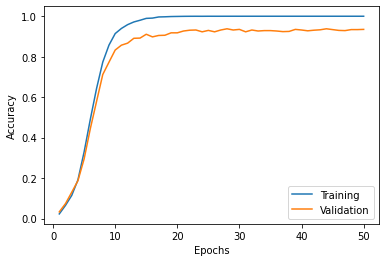

In [8]:
from utils import json_to_numpy, plot_accuracy_trends
legend_list = ["Training", "Validation"]
acc_list = []

epoch_list, train_acc_list, val_acc_list = json_to_numpy("vgg16_vanilla.json")
acc_list.append(train_acc_list)
acc_list.append(val_acc_list)

plot_accuracy_trends(epoch_list, acc_list, legend_list, "Vgg_16")